<a href="https://colab.research.google.com/github/porygon-tech/ECO/blob/main/formulaCheck_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.special import comb  
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def showdata(mat, color=plt.cm.gnuplot, symmetry=False):
    mat = np.copy(mat)
    if symmetry:
        top = np.max([np.abs(np.nanmax(mat)),np.abs(np.nanmin(mat))])
        plt.imshow(mat.astype('float32'), interpolation='none', cmap='seismic',vmax=top,vmin=-top)
    else:
        plt.imshow(mat.astype('float32'), interpolation='none', cmap=color)
    plt.colorbar()
    plt.show()

def samplecolors(n, type='hex',palette=plt.cm.gnuplot):
    if type == 'hex':
        return list(map(plt.cm.colors.rgb2hex, list(map(palette, np.linspace(1,0,n)))))
    elif type == 'rgba':
        return list(map(palette, np.linspace(1,0,n)))

def showlist(l, distbins=False):
            fig = plt.figure(); ax = fig.add_subplot(111)
            ax.plot(np.arange(len(l)),list(l))
            plt.show()

def bindist(n,k,p=0.5):
    return comb(n,k)*p**k*(1-p)**(n-k)

def pOverlaps(n,i,k,x):
    return comb(i,x) * comb(n - i, i + k - x) / comb(n,i+k)


# Introduction
Let us suppose a population of m individuals with n genes coding for a certain trait. The environmental fitness function f defines how natural selection affects an individual's probabilities of reproducing.

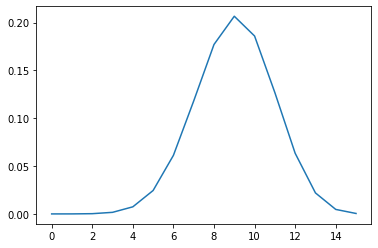

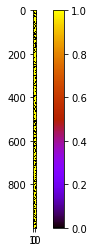

In [19]:
ngenerations = 40
n=15
m=1000

skw=0.6
def f(i):
    #return 1+n-i
    #return 2**(-i/2)
    return n**2-i**2

def f2(i):
    return 1+i
    #return 2**(-i/2)

parent = []
for i in range(n+1):
    parent.append(bindist(n,i,skw))

mtx = np.random.choice((0,1),(m,n), p=(1-skw, skw))

showlist(parent)
showdata(mtx)

# Randomised-matching model calculations

In [ ]:



v_genData=np.zeros((ngenerations, n+1))
v_phen = mtx.sum(axis=1)
unique, counts = np.unique(v_phen, return_counts=True)
np.asarray((unique, counts/m)).T
v_genData[0,(unique).astype(int)] = counts/m

for g in range(1,ngenerations):
    print('generation {0}'.format(g))
    v_phen = mtx.sum(axis=1)
    v_fitn = (f(v_phen)/f(v_phen).sum())[:,np.newaxis]
    #
    #if g>40:
    #    v_fitn = (f2(v_phen)/f2(v_phen).sum())[:,np.newaxis]
    #
    v_pmatch = (v_fitn*v_fitn.T).flatten()[:]
    v_couples = np.random.choice(m**2, m, p=v_pmatch)
    v_couples = np.array(np.unravel_index(v_couples, (m,m)))
    mtx_child = np.zeros((m,n))
    for i in range(m):
        recomb = np.random.choice((0,1),n)
        pA = mtx[v_couples[0,i],:]
        pB = mtx[v_couples[1,i],:]
        mtx_child[i,:] = np.logical_or(np.logical_and(recomb,pA),np.logical_and(np.logical_not(recomb),pB))+0
    #
    v_phen_child = mtx_child.sum(axis=1)
    unique, counts = np.unique(v_phen_child, return_counts=True)
    #np.asarray((unique, counts/m)).T
    v_genData[g,(unique).astype(int)] = counts/m
    mtx = mtx_child.copy()


# Analytical (yet iterated) calculation

In [ ]:

genData=np.zeros((ngenerations, n+1))
genData[0,:] = parent.copy()

fitness=np.zeros(n+1)
for i in range(0,n+1):
    fitness[i] = f(i)

fitness /= fitness.sum()


for g in range(1,ngenerations):
    print('generation {0}'.format(g))
    w=parent*fitness
    w /= w.sum()
    child = np.zeros((n+1))
    for v in range(0,n+1):
        for i in range(0,n+1):
            for j in range(0,n+1):
                for x in range(0,i+1):
                    child[v] += pOverlaps(n,i,j-i,x) * bindist(i - 2*x + j, v - x) * w[i] * w[j]
    genData[g,:] = child.copy()
    parent = child.copy()


# Analysis
As shown in the plots, the randomly produced values are similar to the calculated ones.

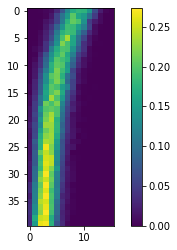

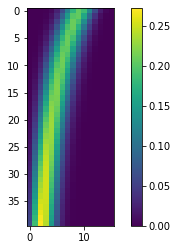

In [15]:
showdata(v_genData, color='viridis')
showdata(genData, color='viridis')

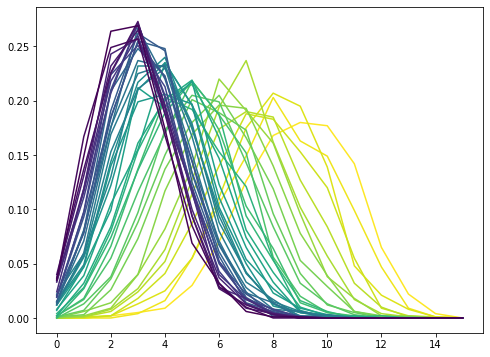

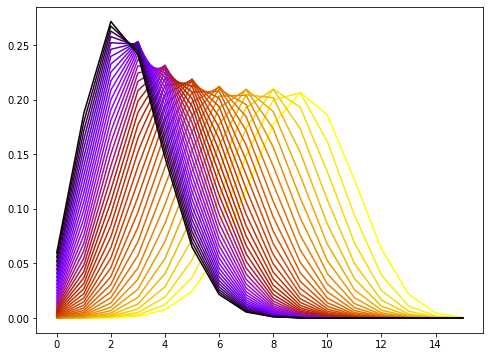

In [14]:

clist   = samplecolors(ngenerations)
clist_v = samplecolors(ngenerations,palette=plt.cm.viridis)

fig = plt.figure(figsize=(8,6)); ax = fig.add_subplot(111)
for g in range(ngenerations):
    ax.plot(np.arange(n+1),v_genData[g,:],label='generation {0}, stochastic'.format(g),color=clist_v[g])

plt.show()

fig = plt.figure(figsize=(8,6)); ax = fig.add_subplot(111)
for g in range(ngenerations):
    ax.plot(np.arange(n+1),  genData[g,:],label='generation {0}'.format(g),color=clist[g])

plt.show()



In [16]:

l_matrix=np.zeros((n+1,n+1,n+1))
for v in range(0,n+1):
    for i in range(0,n+1):
        for j in range(0,n+1):
            for x in range(0,i+1):
                l_matrix[i,j,v] += pOverlaps(n,i,j-i,x) * bindist(i - 2*x + j, v - x) * w[i] * w[j]

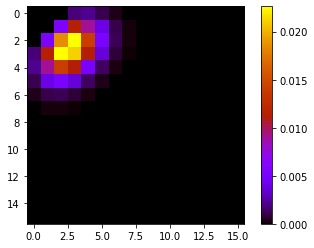

In [18]:
showdata(l_matrix[:,:,3])

In [24]:
from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.animation as animation

In [205]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import copy
my_cmap = copy.copy(plt.cm.get_cmap('gnuplot')) # copy the default cmap
my_cmap.set_bad((0,0,0))


In [ ]:
fig = plt.figure(figsize=(8,6)); ax = fig.add_subplot(111)
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
def frame(w):
    ax.clear()
    global l_matrix
    plot=ax.imshow(l_matrix[:,:,w].astype('float32'), interpolation='none', cmap=my_cmap,vmax=1,vmin=0.000001,norm=LogNorm(vmin=0, vmax=1)) #
    fig.colorbar(plot,ax=ax,cax=cax)
    return plot

In [210]:
anim = animation.FuncAnimation(fig, frame, frames=n+1, blit=False, repeat=True)

In [211]:
anim

In [ ]:
fig = plt.figure(figsize=(8,6)); ax = fig.add_subplot(111)

def frame(w):
    ax.clear()
    global l_matrix
    plot=ax.imshow(l_matrix[:,:,w].astype('float32'), interpolation='none', cmap='gnuplot') #
    return plot

anim = animation.FuncAnimation(fig, frame, frames=n+1, blit=False, repeat=True)



In [185]:
anim